In [1]:
!pip install scikit-image


Train or predict? (t/p):  p
Image path:  /kaggle/input/id-card-tesst/verifave-egyptian-national-id-verification.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Prediction: REAL (89.6% confidence)



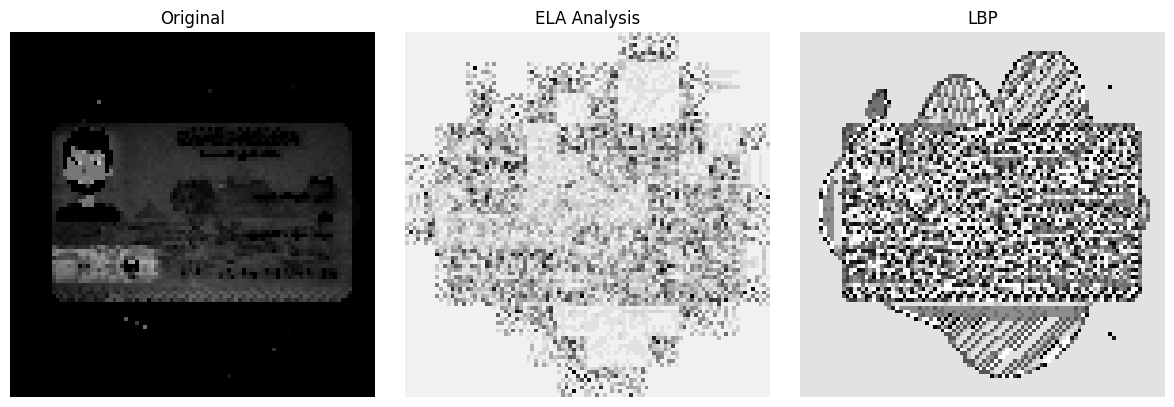

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Input, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
import matplotlib.pyplot as plt
import cv2
from skimage.feature import local_binary_pattern

# Constants
IMG_SIZE = (96, 96)
BATCH_SIZE = 32
EPOCHS = 8
MODEL_PATH = "lbp_ela_deepfake_detector.keras"
VALIDATION_SPLIT = 0.25
MAX_SAMPLES_PER_CLASS = 10000
ELA_QUALITY = 85
ELA_SCALE_FACTOR = 15
LBP_RADIUS = 1
LBP_POINTS = 8 * LBP_RADIUS

def apply_balanced_ela(image_path):
    try:
        original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if original is None:
            return np.zeros((*IMG_SIZE, 3), dtype=np.float32)
        original = cv2.resize(original, IMG_SIZE)
        original_rgb = cv2.merge([original]*3)
        _, encoded = cv2.imencode('.jpg', original, [cv2.IMWRITE_JPEG_QUALITY, ELA_QUALITY])
        compressed = cv2.imdecode(encoded, cv2.IMREAD_GRAYSCALE)
        compressed = cv2.resize(compressed, IMG_SIZE)
        compressed_rgb = cv2.merge([compressed]*3)
        diff = 255 - cv2.absdiff(original_rgb, compressed_rgb)
        return (diff * ELA_SCALE_FACTOR).astype(np.float32) / 255.0
    except Exception as e:
        print(f"ELA failed for {image_path}: {str(e)}")
        return np.zeros((*IMG_SIZE, 3), dtype=np.float32)

def apply_lbp(image_path):
    try:
        gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if gray is None:
            return np.zeros((*IMG_SIZE, 3), dtype=np.float32)
        gray = cv2.resize(gray, IMG_SIZE)
        lbp = local_binary_pattern(gray, P=LBP_POINTS, R=LBP_RADIUS, method='uniform')
        lbp_normalized = (lbp - lbp.min()) / (lbp.max() - lbp.min())
        lbp_rgb = cv2.merge([lbp_normalized.astype(np.float32)]*3)
        return lbp_rgb
    except Exception as e:
        print(f"LBP failed for {image_path}: {str(e)}")
        return np.zeros((*IMG_SIZE, 3), dtype=np.float32)

def load_balanced_image(image_path):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return np.zeros((*IMG_SIZE, 3), dtype=np.float32)
        img = cv2.resize(img, IMG_SIZE)
        img_rgb = cv2.merge([img]*3)
        img_rgb = img_rgb.astype(np.float32)
        img_rgb = (img_rgb / 127.5) - 1.0
        return img_rgb
    except Exception as e:
        print(f"Image loading failed for {image_path}: {str(e)}")
        return np.zeros((*IMG_SIZE, 3), dtype=np.float32)

def create_balanced_generators(real_dir, fake_dir):
    real_images = [os.path.join(real_dir, f) for f in os.listdir(real_dir)
                   if f.lower().endswith(('.jpg', '.png', '.jpeg'))][:MAX_SAMPLES_PER_CLASS]
    fake_images = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir)
                   if f.lower().endswith(('.jpg', '.png', '.jpeg'))][:MAX_SAMPLES_PER_CLASS]
    file_paths = np.array(real_images + fake_images)
    labels = np.array([1]*len(real_images) + [0]*len(fake_images))
    indices = np.random.permutation(len(file_paths))
    file_paths = file_paths[indices]
    labels = labels[indices]
    split_idx = int(len(file_paths) * VALIDATION_SPLIT)
    train_files, val_files = file_paths[split_idx:], file_paths[:split_idx]
    train_labels, val_labels = labels[split_idx:], labels[:split_idx]

    print("\nBalanced Dataset Statistics:")
    print(f"Training - Real: {sum(train_labels)}, Fake: {len(train_labels)-sum(train_labels)}")
    print(f"Validation - Real: {sum(val_labels)}, Fake: {len(val_labels)-sum(val_labels)}\n")

    def preprocess_batch(files, labels, augment=False):
        originals, elas, lbps = [], [], []
        for file in files:
            img = load_balanced_image(file)
            ela = apply_balanced_ela(file)
            lbp = apply_lbp(file)
            if augment:
                if np.random.rand() > 0.5:
                    img = np.fliplr(img)
                    ela = np.fliplr(ela)
                    lbp = np.fliplr(lbp)
                if np.random.rand() > 0.5:
                    angle = np.random.uniform(-15, 15)
                    M = cv2.getRotationMatrix2D((IMG_SIZE[0]//2, IMG_SIZE[1]//2), angle, 1)
                    img = cv2.warpAffine(img, M, IMG_SIZE)
                    ela = cv2.warpAffine(ela, M, IMG_SIZE)
                    lbp = cv2.warpAffine(lbp, M, IMG_SIZE)
            originals.append(img)
            elas.append(ela)
            lbps.append(lbp)
        return {
            'original_input': np.array(originals),
            'ela_input': np.array(elas),
            'lbp_input': np.array(lbps)
        }, np.array(labels, dtype=np.float32)

    def train_generator():
        while True:
            for i in range(0, len(train_files), BATCH_SIZE):
                yield preprocess_batch(train_files[i:i+BATCH_SIZE], train_labels[i:i+BATCH_SIZE], augment=True)

    def val_generator():
        while True:
            for i in range(0, len(val_files), BATCH_SIZE):
                yield preprocess_batch(val_files[i:i+BATCH_SIZE], val_labels[i:i+BATCH_SIZE], augment=False)

    train_ds = tf.data.Dataset.from_generator(
        train_generator,
        output_signature=(
            {
                'original_input': tf.TensorSpec(shape=(None, *IMG_SIZE, 3)),
                'ela_input': tf.TensorSpec(shape=(None, *IMG_SIZE, 3)),
                'lbp_input': tf.TensorSpec(shape=(None, *IMG_SIZE, 3))
            },
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    ).prefetch(tf.data.AUTOTUNE)

    val_ds = tf.data.Dataset.from_generator(
        val_generator,
        output_signature=(
            {
                'original_input': tf.TensorSpec(shape=(None, *IMG_SIZE, 3)),
                'ela_input': tf.TensorSpec(shape=(None, *IMG_SIZE, 3)),
                'lbp_input': tf.TensorSpec(shape=(None, *IMG_SIZE, 3))
            },
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    ).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, len(train_files)//BATCH_SIZE, len(val_files)//BATCH_SIZE

def build_balanced_model(input_shape):
    original_input = Input(shape=input_shape, name='original_input')
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    original_features = GlobalAveragePooling2D()(base_model(original_input))

    ela_input = Input(shape=input_shape, name='ela_input')
    ela_x = Conv2D(32, (3, 3), activation='relu', padding='same')(ela_input)
    ela_x = MaxPooling2D(pool_size=(2, 2))(ela_x)
    ela_x = Conv2D(64, (3, 3), activation='relu', padding='same')(ela_x)
    ela_x = MaxPooling2D(pool_size=(2, 2))(ela_x)
    ela_features = GlobalAveragePooling2D()(ela_x)

    lbp_input = Input(shape=input_shape, name='lbp_input')
    lbp_x = Conv2D(32, (3, 3), activation='relu', padding='same')(lbp_input)
    lbp_x = MaxPooling2D(pool_size=(2, 2))(lbp_x)
    lbp_x = Conv2D(64, (3, 3), activation='relu', padding='same')(lbp_x)
    lbp_x = MaxPooling2D(pool_size=(2, 2))(lbp_x)
    lbp_features = GlobalAveragePooling2D()(lbp_x)

    combined = Concatenate()([original_features, ela_features, lbp_features])
    x = Dense(96, activation='relu')(combined)
    x = Dropout(0.4)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[original_input, ela_input, lbp_input], outputs=predictions)
    model.compile(optimizer=Adam(3e-6), loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

def train_balanced_model():
    real_dir = '/kaggle/input/egyptians-ids-dataset/Egyptians IDs DataSet/Real'
    fake_dir = '/kaggle/input/egyptians-ids-dataset/Egyptians IDs DataSet/Img'

    try:
        train_ds, val_ds, steps_per_epoch, validation_steps = create_balanced_generators(real_dir, fake_dir)
        model = build_balanced_model((*IMG_SIZE, 3))

        callbacks = [
            EarlyStopping(patience=4, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.25, patience=2),
            CSVLogger('balanced_training.csv')
        ]

        history = model.fit(
            train_ds,
            steps_per_epoch=steps_per_epoch,
            validation_data=val_ds,
            validation_steps=validation_steps,
            epochs=EPOCHS,
            callbacks=callbacks,
            verbose=1
        )

        model.save(MODEL_PATH)
        print(f"\nModel saved to {MODEL_PATH}")

        plt.figure(figsize=(15, 10))
        plt.subplot(2, 2, 1)
        plt.plot(history.history['accuracy'], label='Train')
        plt.plot(history.history['val_accuracy'], label='Validation')
        plt.title('Accuracy')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.title('Loss')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(history.history['precision'], label='Train')
        plt.plot(history.history['val_precision'], label='Validation')
        plt.title('Precision')
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(history.history['recall'], label='Train')
        plt.plot(history.history['val_recall'], label='Validation')
        plt.title('Recall')
        plt.legend()

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Training failed: {str(e)}")

def predict_image(image_path):
    try:
        model = tf.keras.models.load_model(MODEL_PATH)
        img = load_balanced_image(image_path)
        ela = apply_balanced_ela(image_path)
        lbp = apply_lbp(image_path)
        pred = model.predict({
            'original_input': np.expand_dims(img, axis=0),
            'ela_input': np.expand_dims(ela, axis=0),
            'lbp_input': np.expand_dims(lbp, axis=0)
        })[0][0]
        result = "REAL" if pred > 0.5 else "FAKE"
        confidence = max(pred, 1 - pred) * 100

        print("\n" + "="*50)
        print(f"Prediction: {result} ({confidence:.1f}% confidence)")
        print("="*50 + "\n")

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Original")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(ela)
        plt.title("ELA Analysis")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(lbp)
        plt.title("LBP")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Prediction failed: {str(e)}")

if __name__ == "__main__":
    action = input("Train or predict? (t/p): ").lower()
    if action == 't':
        train_balanced_model()
    elif action == 'p':
        img_path = input("Image path: ")
        predict_image(img_path)
    else:
        print("Invalid choice")
